<a href="https://colab.research.google.com/github/armarmarm927/dl_lecture_competition_pub/blob/main/sparkproto14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [37]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine([-10,10],scale=(1,1.25)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomErasing(p=0.5,scale=(0.02,0.33),ratio=(0.3,3.3),value=0,inplace=False)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [38]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [39]:
model_ft = models.resnet50(pretrained=True)
model_ft.fc = nn.Linear(model_ft.fc.in_features, 10)
net = model_ft.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

In [41]:
num_epochs = 50
loss_list = []
acc_list = []
train_acc_list = []

for epoch in range(num_epochs):
    net.train()
    correct_train = 0
    total_train = 0
    epoch_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = 100. * correct_train / total_train
    train_acc_list.append(train_accuracy)
    print(f'Epoch {epoch+1}: Loss: {epoch_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%')
    loss_list.append(epoch_loss/len(train_loader))

    net.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    test_accuracy = 100. * correct / total
    acc_list.append(test_accuracy)
    print(f'Test Accuracy: {test_accuracy:.2f}%')

    # 混同行列の出力
    cm = confusion_matrix(y_true, y_pred)
    print(f'Confusion Matrix (Epoch {epoch+1}):')
    print(cm)

    torch.save(net.state_dict(), '/content/drive/MyDrive/Weight_Epoch50.pth')
    scheduler.step()

Epoch 1: Loss: 1.2473, Train Accuracy: 57.48%
Test Accuracy: 68.82%
Confusion Matrix (Epoch 1):
[[699  33  97   5  19   2   5   7  85  48]
 [ 13 913   6   0   3   3   4   1  13  44]
 [ 81   5 619  21 160  23  47  18  12  14]
 [ 36  12 111 394 173 103  83  35  20  33]
 [ 31   5  57   9 829   7  22  26   6   8]
 [ 14   6 177 109 103 475  19  64  17  16]
 [  9  13  81  44 115  10 715   3   5   5]
 [ 25   6  51  22 121  18   6 721   5  25]
 [107  62  14   5   3   0   7   0 769  33]
 [ 22 186   4   2   4   0   6   2  26 748]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2: Loss: 0.9326, Train Accuracy: 67.94%
Test Accuracy: 76.53%
Confusion Matrix (Epoch 2):
[[749  14  46  18   9   1   4  11 110  38]
 [ 14 917   3   3   3   4   2   4  17  33]
 [ 45   6 596  51  80  74  86  27  23  12]
 [ 21   7  27 565  56 171  76  43  22  12]
 [ 13   3  46  32 733  27  57  73  12   4]
 [  8   4  23 121  34 720  20  53   8   9]
 [  9  11  23  50  21  23 849   6   5   3]
 [ 20   5   6  49  24  32   7 832   4  21]
 [ 49  37   5   6   6   2   0   3 879  13]
 [ 27  99   3   7   1   3   2  10  35 813]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 3: Loss: 0.7827, Train Accuracy: 73.01%
Test Accuracy: 78.84%
Confusion Matrix (Epoch 3):
[[827   8  24   9  11   3   6   7  74  31]
 [ 11 863   8   0   2   4   7   1  33  71]
 [ 57   0 709  16  89  44  45  29   5   6]
 [ 18   5  93 399  62 283  50  72  11   7]
 [ 15   1  40  16 793  40  38  45  11   1]
 [  5   2  44  41  33 768  19  82   4   2]
 [  3   1  42  22  23  26 870   5   6   2]
 [ 22   1  17  14  43  21   7 860   2  13]
 [ 37   9  14   3   2   3   1   2 918  11]
 [ 23  45   8   3   1   6   6   3  28 877]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 4: Loss: 0.7276, Train Accuracy: 75.01%
Test Accuracy: 79.92%
Confusion Matrix (Epoch 4):
[[793  13  50  12  27   0   5  13  72  15]
 [  7 856   3   3   3   4   8   1  36  79]
 [ 35   1 736  19  97  34  48  19   8   3]
 [ 16   3  71 548  79 181  58  30   9   5]
 [  7   1  38  18 853  10  18  50   5   0]
 [  6   0  55 102  43 719  19  54   2   0]
 [  3   0  33  20  49  22 859   8   5   1]
 [  8   2  20  30  39  35   5 848   8   5]
 [ 29  10   9   3  11   2   2   3 926   5]
 [ 19  31   7   7   6   5   0  12  59 854]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 5: Loss: 0.7407, Train Accuracy: 74.57%
Test Accuracy: 79.93%
Confusion Matrix (Epoch 5):
[[837  12  23  11   4   3   5   8  54  43]
 [ 12 917   4   3   2   5   1   0   7  49]
 [ 67   3 789  21  35  48  15  11   7   4]
 [ 18   1  73 578  27 239  22  26   9   7]
 [ 19   1 109  53 726  35  18  28  11   0]
 [  9   0  37  92  19 814   4  24   1   0]
 [  3   4  71  57  21  56 772   4  10   2]
 [ 18   1  19  30  43  53   3 825   3   5]
 [ 53  37   7   5   1   4   0   2 876  15]
 [ 25  68   8  10   0   4   1   7  18 859]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 6: Loss: 0.6571, Train Accuracy: 77.24%
Test Accuracy: 81.05%
Confusion Matrix (Epoch 6):
[[817  18  31  23  19   1   4  10  61  16]
 [  5 949   4   4   1   1   1   1  12  22]
 [ 45   3 750  55  71  28  24  18   6   0]
 [ 12   7  38 709  45 109  30  30  15   5]
 [  5   3  37  55 805  27  14  48   6   0]
 [  7   1  39 164  52 688   7  35   7   0]
 [  4   6  37  87  14  36 804   7   4   1]
 [ 14   3  15  29  22  29   1 878   5   4]
 [ 37  22  10  11   7   0   3   3 899   8]
 [ 27 104   4  13   1   4   1  10  30 806]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 7: Loss: 0.6182, Train Accuracy: 78.36%
Test Accuracy: 81.32%
Confusion Matrix (Epoch 7):
[[814  12  24   6   7   1   4   6  91  35]
 [  8 876   3   0   0   1   2   0  22  88]
 [ 52   1 785  15  33  40  37  17  11   9]
 [ 20   4  70 511  26 210  70  46  20  23]
 [  6   1  81  27 734  20  36  80   9   6]
 [ 12   1  34  70  21 776  19  51   7   9]
 [  3   4  37  20  11  20 892   6   4   3]
 [ 15   2  22  10  14  33   3 885   3  13]
 [ 16  16   4   0   2   2   0   2 938  20]
 [ 14  30   2   1   0   4   2   2  24 921]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 8: Loss: 0.5845, Train Accuracy: 79.69%
Test Accuracy: 80.12%
Confusion Matrix (Epoch 8):
[[891   6   9   5   4   0   3   2  66  14]
 [ 17 910   1   1   1   2   1   1  22  44]
 [100   4 707  22  55  20  32  21  31   8]
 [ 41  16  54 590  43 103  59  23  49  22]
 [ 22   2  34  22 792  16  47  25  38   2]
 [ 20   4  48 125  30 683  24  33  17  16]
 [ 26   3  34  21   9   6 839   3  49  10]
 [ 25   4   9  25  31  19   3 861  14   9]
 [ 57  24   6   3   1   0   0   1 889  19]
 [ 46  72   4   4   0   0   0   4  20 850]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 9: Loss: 0.5752, Train Accuracy: 80.17%
Test Accuracy: 82.53%
Confusion Matrix (Epoch 9):
[[858  14  25  13   5   1   4   9  50  21]
 [  5 900   3   7   1   1   5   7  24  47]
 [ 51   0 771  36  53  13  34  30  10   2]
 [ 17   3  44 695  36  95  46  43  17   4]
 [  9   1  31  54 791  11  25  67  11   0]
 [  9   0  41 171  22 657  16  78   6   0]
 [  6   1  31  31  14  12 890  11   4   0]
 [  8   0   9  23  11   3   0 931   7   8]
 [ 41  11  10  13   2   1   5   4 901  12]
 [ 23  51   9  21   0   3   3   8  23 859]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 10: Loss: 0.7830, Train Accuracy: 73.70%
Test Accuracy: 72.12%
Confusion Matrix (Epoch 10):
[[803  19  34  21  13   9   4  18  52  27]
 [ 24 797   7  11   1   2   4   7  18 129]
 [ 80   8 620  41  77  53  30  63  17  11]
 [ 20  12  53 544  50 194  32  80   7   8]
 [ 33   6  54  44 729  41  10  71   6   6]
 [ 12   6  33 124  32 698  10  77   3   5]
 [  7  13  52  60  40  33 755  28   5   7]
 [ 20   3   3  19  32  46   1 864   0  12]
 [206 104  11   9   5   2   0  10 626  27]
 [ 44 109   5  11   5   3   4  12  31 776]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 11: Loss: 1.1302, Train Accuracy: 61.75%
Test Accuracy: 75.49%
Confusion Matrix (Epoch 11):
[[828  28  30   9   4   1   8   4  48  40]
 [ 24 831   0   1   0   4   6   2  20 112]
 [ 75  14 661  34  65  58  64  13  12   4]
 [ 35  26  51 573  40 158  50  26  19  22]
 [ 40  10  66  50 674  20  43  68  24   5]
 [ 16  12  42 124  35 688  23  43   7  10]
 [  8  12  33  44  19  22 842   5  10   5]
 [ 30   6  31  38  26  38   9 795   5  22]
 [ 65  58  10   6   2   3   2   2 810  42]
 [ 30  81   4  10   0   2   1   1  24 847]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 12: Loss: 0.7306, Train Accuracy: 74.64%
Test Accuracy: 81.82%
Confusion Matrix (Epoch 12):
[[854  16  17   9  17   0   3   6  39  39]
 [  7 933   3   1   2   2   1   1  10  40]
 [ 63   4 715  30  84  31  36  25   5   7]
 [ 21  14  49 594  55 155  55  30  15  12]
 [ 14   2  21  22 849  16  24  45   6   1]
 [ 12   0  34 101  42 743  12  44   5   7]
 [  9   5  33  24  19  16 879   4   8   3]
 [ 14   1  16  21  22  26   3 886   3   8]
 [ 54  37   6   6   4   1   1   1 871  19]
 [ 29  76   3   3   2   3   1   2  23 858]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 13: Loss: 0.6078, Train Accuracy: 78.90%
Test Accuracy: 76.24%
Confusion Matrix (Epoch 13):
[[809  63  17   8  17   4   4   6  43  29]
 [ 18 793   9   5   6  10  11   2  25 121]
 [ 98   8 733  14  56  35  28  17   5   6]
 [ 24   8  78 503  70 223  36  27  15  16]
 [ 14   1  63  18 813  26  29  26   5   5]
 [ 11   3  53  56  53 756  17  37   3  11]
 [ 11   6  52  35  23  20 838   3   8   4]
 [ 21   6  31  22  43  34   9 815   1  18]
 [ 67 109   9   9   7   6   0   3 767  23]
 [ 26 120   4   8   3   6   4   7  25 797]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 14: Loss: 0.6575, Train Accuracy: 77.42%
Test Accuracy: 82.30%
Confusion Matrix (Epoch 14):
[[867  16  26  17   7   6   6  10  21  24]
 [  5 946   0   4   1   5   5   1   6  27]
 [ 39   7 744  47  50  58  27  19   3   6]
 [ 18   6  21 673  37 171  38  18   9   9]
 [ 14   1  36  52 809  19  29  36   1   3]
 [ 10   3  13 109  28 795  15  21   1   5]
 [  5   9  28  39  14  13 883   5   2   2]
 [  7   5  14  26  26  46   1 866   2   7]
 [ 80  55   6   9   3   3   1   3 823  17]
 [ 19 122   4  12   0   5   0   3  11 824]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 15: Loss: 0.5456, Train Accuracy: 81.15%
Test Accuracy: 83.43%
Confusion Matrix (Epoch 15):
[[854  11  56   4   8   0   5   7  36  19]
 [ 12 919   4   0   2   3   2   3  21  34]
 [ 30   2 816  15  63  26  17  20   2   9]
 [ 22   6  52 657  46 126  33  34  13  11]
 [ 11   2  37  27 852  10  19  38   3   1]
 [  9   2  38 117  39 735   6  46   4   4]
 [ 10   2  57  31  29  18 837   6   7   3]
 [  7   1  15  18  15  17   0 915   3   9]
 [ 49  13  10   8   3   1   2   1 904   9]
 [ 25  82   7   9   0   5   0   2  16 854]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 16: Loss: 0.5016, Train Accuracy: 82.51%
Test Accuracy: 84.23%
Confusion Matrix (Epoch 16):
[[881   7  39   6   8   1   5   4  33  16]
 [ 20 929   6   3   0   3   4   0  17  18]
 [ 37   3 848  20  30  31  20   9   2   0]
 [ 17   2  68 668  43 147  34  13   3   5]
 [  8   1  67  29 843  16  20  14   2   0]
 [ 12   0  36 108  35 783  11  14   0   1]
 [  7   1  46  28  12  24 878   1   1   2]
 [ 15   2  24  32  33  44   3 844   0   3]
 [ 39  12  16   7   2   8   2   0 908   6]
 [ 24  74   9  11   0  12   2   6  21 841]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 17: Loss: 0.4806, Train Accuracy: 83.07%
Test Accuracy: 84.46%
Confusion Matrix (Epoch 17):
[[884   9  40  15   8   1   4   4  23  12]
 [  9 925   3   2   2   2   1   1  21  34]
 [ 31   6 837  25  46  23  11  12   5   4]
 [ 10   5  58 695  29 136  33  17  10   7]
 [ 10   1  47  35 822  25  23  34   2   1]
 [ 10   2  41 124  20 764  12  22   2   3]
 [  3   3  42  38  12  18 875   3   4   2]
 [ 11   0  25  28  22  39   2 865   2   6]
 [ 52   9   9   9   3   0   1   1 905  11]
 [ 29  51   4  11   0   4   1   5  21 874]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 18: Loss: 0.4656, Train Accuracy: 83.80%
Test Accuracy: 83.87%
Confusion Matrix (Epoch 18):
[[859   4  31  25   5  10  10   2  20  34]
 [ 14 906   5   8   0   9   2   1  16  39]
 [ 35   0 811  44  26  44  28   7   2   3]
 [  8   1  30 733  19 164  32   4   4   5]
 [ 11   1  55  61 777  31  47  16   0   1]
 [  6   1  22 118  20 811  11   9   0   2]
 [  3   2  24  54   7  20 884   0   4   2]
 [  9   0  17  55  30  72   2 809   0   6]
 [ 53  10   8  18   2   3   0   0 890  16]
 [ 13  35   3  14   0  15   1   0  12 907]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 19: Loss: 0.4544, Train Accuracy: 84.12%
Test Accuracy: 83.98%
Confusion Matrix (Epoch 19):
[[904   3  29   4   9   0   4   8  25  14]
 [ 23 879   1   1   1   2   4   4  26  59]
 [ 32   1 791  23  75  18  20  28   9   3]
 [ 22   4  30 628  57 140  44  52  15   8]
 [ 13   1  20  27 852  17  17  49   3   1]
 [ 13   3  23  85  39 741  15  70   5   6]
 [  2   1  32  26  27   8 874   9  14   7]
 [  9   0  11  13  19  12   2 930   3   1]
 [ 60   9   6   5   3   1   0   1 902  13]
 [ 37  24   2   3   0   2   1  10  24 897]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 20: Loss: 0.4421, Train Accuracy: 84.50%
Test Accuracy: 84.96%
Confusion Matrix (Epoch 20):
[[897  10  23   5   7   0   6   4  34  14]
 [ 12 928   2   2   0   1   4   0  27  24]
 [ 44   0 796  20  45  27  41  17   8   2]
 [ 27   5  54 639  42 133  60  17  17   6]
 [ 10   3  32  28 827  22  37  35   4   2]
 [ 12   3  36  93  20 786  13  27   5   5]
 [  2   3  19  12   7  15 933   2   3   4]
 [ 18   3  15  20  24  34   3 876   4   3]
 [ 39   7   8   3   2   2   1   0 930   8]
 [ 25  59   1   3   0   2   2   0  24 884]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 21: Loss: 0.3494, Train Accuracy: 87.83%
Test Accuracy: 86.80%
Confusion Matrix (Epoch 21):
[[905   7  21  10   7   0   5   6  26  13]
 [  8 939   2   4   0   3   4   2  10  28]
 [ 35   0 840  23  40  26  21  10   4   1]
 [ 13   3  44 719  40 123  30  17   8   3]
 [  5   1  37  31 864  13  23  23   3   0]
 [  5   3  23 102  25 802   9  27   4   0]
 [  2   1  29  24  11  14 912   1   4   2]
 [ 13   1  15  24  22  32   3 887   1   2]
 [ 36  15  10   7   4   2   1   0 916   9]
 [ 23  53   3   8   0   2   2   1  12 896]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 22: Loss: 0.3183, Train Accuracy: 88.73%
Test Accuracy: 87.11%
Confusion Matrix (Epoch 22):
[[909   5  21   7   6   2   5   5  28  12]
 [  9 941   4   4   0   3   2   0  11  26]
 [ 32   0 862  23  31  24  14   9   3   2]
 [ 14   3  41 740  30 126  21  12  10   3]
 [  6   1  45  38 850  12  20  25   3   0]
 [  7   2  21 111  22 806  11  16   2   2]
 [  2   4  33  30  11  15 898   1   3   3]
 [ 11   1  18  28  20  30   3 883   3   3]
 [ 35  12   7  11   4   1   0   0 921   9]
 [ 20  53   3   6   0   5   1   0  11 901]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 23: Loss: 0.3077, Train Accuracy: 89.23%
Test Accuracy: 87.22%
Confusion Matrix (Epoch 23):
[[912   7  17   5   5   1   3   7  29  14]
 [  9 950   2   2   0   2   1   2   7  25]
 [ 32   1 860  18  34  19  16  12   5   3]
 [ 16   3  42 747  33 102  23  18   9   7]
 [  5   2  44  33 855  12  20  23   4   2]
 [  9   2  31 118  23 770  13  29   2   3]
 [  2   4  34  27  10  12 904   1   3   3]
 [ 10   2  16  21  20  27   3 896   3   2]
 [ 28  16   7   5   3   1   1   0 929  10]
 [ 20  55   1   5   0   3   1   2  14 899]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 24: Loss: 0.2990, Train Accuracy: 89.60%
Test Accuracy: 87.51%
Confusion Matrix (Epoch 24):
[[919   5  15   8   7   2   5   5  21  13]
 [ 11 937   3   4   0   4   4   1   6  30]
 [ 33   0 848  25  36  24  18  10   4   2]
 [ 13   3  30 756  30 119  26  14   6   3]
 [  4   1  36  35 866  13  24  18   3   0]
 [  5   1  18 114  27 801  11  21   1   1]
 [  1   2  29  25   8  11 919   1   1   3]
 [ 10   1  14  26  23  30   4 889   1   2]
 [ 43  16   7  12   4   1   0   0 908   9]
 [ 18  43   3   7   0   5   2   1  13 908]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 25: Loss: 0.2822, Train Accuracy: 90.08%
Test Accuracy: 87.59%
Confusion Matrix (Epoch 25):
[[917   4  24   4   8   2   3   5  23  10]
 [  9 942   3   5   0   1   2   0  11  27]
 [ 26   0 861  19  35  23  18  13   4   1]
 [ 14   3  42 721  30 129  30  21   6   4]
 [  5   1  38  30 869  13  22  20   2   0]
 [  6   1  22  96  22 819   9  21   3   1]
 [  2   3  28  23  10  14 913   2   3   2]
 [ 11   1  13  26  21  27   4 893   2   2]
 [ 32  14   7   5   2   2   1   0 929   8]
 [ 21  52   3   6   0   5   1   1  16 895]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 26: Loss: 0.2772, Train Accuracy: 90.36%
Test Accuracy: 87.54%
Confusion Matrix (Epoch 26):
[[923   5  11   4   6   1   5   5  27  13]
 [  8 935   2   5   0   2   3   0  14  31]
 [ 34   0 844  23  36  22  20  12   5   4]
 [ 16   3  33 750  28 115  28  16   8   3]
 [  5   1  34  36 864  13  26  17   4   0]
 [ 10   2  18 116  23 795  11  20   3   2]
 [  2   3  25  29  11  11 913   2   2   2]
 [  9   1  13  21  20  36   4 892   2   2]
 [ 29  12   6   9   2   1   0   0 932   9]
 [ 15  49   2   5   0   4   1   2  16 906]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 27: Loss: 0.2717, Train Accuracy: 90.39%
Test Accuracy: 87.75%
Confusion Matrix (Epoch 27):
[[911   5  19   8   7   1   5   6  23  15]
 [ 10 937   3   6   0   1   2   1   8  32]
 [ 30   1 847  24  36  22  19  17   2   2]
 [ 12   2  30 744  36 120  27  18   7   4]
 [  5   1  36  30 878  11  17  19   3   0]
 [  8   1  17 104  26 804  14  23   1   2]
 [  1   2  26  25  13  13 915   1   1   3]
 [  7   1  12  27  18  26   4 901   1   3]
 [ 29  14   7  11   2   0   0   0 925  12]
 [ 17  42   2   6   0   4   1   2  13 913]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 28: Loss: 0.2590, Train Accuracy: 90.82%
Test Accuracy: 87.49%
Confusion Matrix (Epoch 28):
[[909   4  20   4   7   3   4   6  23  20]
 [  9 933   3   3   0   2   1   0  13  36]
 [ 26   1 861  21  34  21  15  16   3   2]
 [  9   2  37 736  33 121  27  21   9   5]
 [  4   1  38  32 861  15  18  28   3   0]
 [  5   1  20 111  20 804  12  23   1   3]
 [  1   2  36  30  14  13 896   1   3   4]
 [  8   1  15  19  16  30   3 904   2   2]
 [ 24  14   7   8   2   1   0   0 932  12]
 [ 15  43   1   6   0   4   1   4  13 913]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 29: Loss: 0.2578, Train Accuracy: 90.94%
Test Accuracy: 87.75%
Confusion Matrix (Epoch 29):
[[916   7  13   4   9   2   2   5  25  17]
 [  7 943   4   3   0   2   2   0  10  29]
 [ 29   0 858  21  34  19  18  15   4   2]
 [ 10   2  36 734  37 125  29  16   6   5]
 [  4   1  37  35 863  16  20  21   3   0]
 [  8   0  21  96  24 813  13  21   2   2]
 [  1   2  27  29  12  15 908   1   1   4]
 [  7   1  14  24  19  28   3 901   0   3]
 [ 23  11   8  10   2   2   0   0 932  12]
 [ 14  47   3   6   0   4   1   2  16 907]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 30: Loss: 0.2545, Train Accuracy: 91.12%
Test Accuracy: 87.67%
Confusion Matrix (Epoch 30):
[[920   4   9   7   7   1   4   4  28  16]
 [  7 940   3   5   0   1   1   0  16  27]
 [ 40   0 842  25  33  23  17  12   5   3]
 [ 13   6  29 772  29  99  22  17   7   6]
 [  8   1  37  37 856  13  16  27   3   2]
 [ 11   1  16 126  22 784  11  23   2   4]
 [  2   3  30  36  10  12 898   1   4   4]
 [  9   1   9  24  17  21   2 912   1   4]
 [ 26  10   7   8   2   0   0   0 935  12]
 [ 17  51   1   6   0   3   1   1  12 908]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 31: Loss: 0.2435, Train Accuracy: 91.46%
Test Accuracy: 87.54%
Confusion Matrix (Epoch 31):
[[904   5  19   9   8   2   4   6  27  16]
 [ 11 935   3   7   0   0   2   0  14  28]
 [ 29   1 861  24  29  21  17  13   3   2]
 [ 12   4  36 765  29 106  25  14   5   4]
 [  6   1  42  40 859  16  15  20   1   0]
 [ 11   1  21 115  25 790  15  20   0   2]
 [  1   2  31  27  10  11 911   1   2   4]
 [  9   0  12  23  17  31   4 901   0   3]
 [ 25  11  11  10   2   1   0   0 930  10]
 [ 16  54   2   8   0   4   1   3  14 898]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 32: Loss: 0.2418, Train Accuracy: 91.47%
Test Accuracy: 87.60%
Confusion Matrix (Epoch 32):
[[911   5  21   8  10   3   4   5  20  13]
 [  6 946   3   5   0   2   2   1   9  26]
 [ 27   1 855  26  37  16  18  12   5   3]
 [  8   1  27 793  37  89  22  16   5   2]
 [  4   1  32  30 876  17  18  21   1   0]
 [  8   0  22 157  28 748   9  24   1   3]
 [  2   2  29  34   9   7 910   1   2   4]
 [  8   2   9  26  23  27   3 899   1   2]
 [ 30  16   8  11   3   1   0   0 923   8]
 [ 17  52   2   7   0   4   1   4  14 899]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 33: Loss: 0.2351, Train Accuracy: 91.76%
Test Accuracy: 87.70%
Confusion Matrix (Epoch 33):
[[927   4  15   4   5   2   5   3  24  11]
 [  8 948   2   5   0   1   1   0   9  26]
 [ 35   0 848  24  33  22  16  13   7   2]
 [ 12   3  34 762  32 103  24  20   8   2]
 [  7   1  31  37 864  17  15  24   4   0]
 [  9   1  16 122  26 785  12  25   3   1]
 [  1   3  27  29  12  10 910   2   3   3]
 [  9   2  13  22  18  25   2 906   1   2]
 [ 30  19   6   8   2   0   0   0 927   8]
 [ 22  54   2   5   0   2   1   3  18 893]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 34: Loss: 0.2326, Train Accuracy: 91.77%
Test Accuracy: 87.88%
Confusion Matrix (Epoch 34):
[[923   1  11   5   7   2   5   4  24  18]
 [ 11 927   3   4   0   2   3   2  16  32]
 [ 36   0 849  19  37  21  20  11   4   3]
 [ 11   3  32 735  41 121  30  16   7   4]
 [  6   1  31  27 887  13  17  16   2   0]
 [  9   0  18 109  29 798  11  22   1   3]
 [  1   3  24  28   9  10 920   1   1   3]
 [  8   2  13  16  19  28   5 907   0   2]
 [ 28   9   7  10   2   3   0   0 931  10]
 [ 18  42   1   5   0   5   1   3  14 911]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 35: Loss: 0.2328, Train Accuracy: 91.72%
Test Accuracy: 87.69%
Confusion Matrix (Epoch 35):
[[916   4  20   5   7   2   5   4  24  13]
 [  7 952   3   3   0   2   1   1   7  24]
 [ 29   1 860  21  33  24  15  11   3   3]
 [ 12   2  35 748  33 117  29  15   6   3]
 [  5   1  36  37 859  17  16  27   2   0]
 [  7   2  18 111  26 803   9  21   0   3]
 [  1   3  32  33  12  12 900   2   3   2]
 [  6   1  15  19  16  30   3 907   1   2]
 [ 27  20   6  10   3   2   0   0 923   9]
 [ 15  53   2   8   0   4   1   2  14 901]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 36: Loss: 0.2231, Train Accuracy: 92.14%
Test Accuracy: 87.80%
Confusion Matrix (Epoch 36):
[[909   6  18   8   7   3   6   5  24  14]
 [  6 943   2   6   0   1   2   2   9  29]
 [ 29   0 869  19  32  18  16  10   5   2]
 [  8   2  43 758  36 105  25  15   4   4]
 [  4   1  39  35 871  14  14  20   2   0]
 [  6   0  23 120  27 789  11  21   2   1]
 [  1   3  29  34  10  10 905   2   4   2]
 [  7   1  13  21  18  30   3 905   0   2]
 [ 24  10   8   9   3   3   0   0 935   8]
 [ 14  56   3   6   0   6   1   2  16 896]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 37: Loss: 0.2167, Train Accuracy: 92.40%
Test Accuracy: 87.78%
Confusion Matrix (Epoch 37):
[[922   4  15   5   8   1   5   6  21  13]
 [  7 944   4   4   0   1   1   2   9  28]
 [ 27   0 860  24  33  17  16  16   5   2]
 [ 14   4  33 750  32 115  28  16   5   3]
 [  5   1  36  35 866  16  11  28   2   0]
 [  8   0  24 116  29 782  12  26   2   1]
 [  1   3  29  30  11   9 909   2   3   3]
 [ 10   1   9  25  14  21   4 913   1   2]
 [ 26  10   8  11   3   0   0   0 932  10]
 [ 22  48   2   5   0   4   1   3  15 900]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 38: Loss: 0.2183, Train Accuracy: 92.27%
Test Accuracy: 87.76%
Confusion Matrix (Epoch 38):
[[906   4  17   7   7   2   5   5  31  16]
 [  9 941   3   2   0   2   2   1   8  32]
 [ 29   1 844  28  35  25  18  11   5   4]
 [  7   5  29 751  33 126  26  10   7   6]
 [  6   1  31  45 853  19  17  25   2   1]
 [  7   0  14 107  20 823   8  17   1   3]
 [  1   5  27  30   9  11 909   1   2   5]
 [ 10   2   8  22  15  30   2 908   1   2]
 [ 26  15   5   8   2   4   0   0 931   9]
 [ 17  47   2   3   0   5   1   1  14 910]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 39: Loss: 0.2092, Train Accuracy: 92.70%
Test Accuracy: 87.71%
Confusion Matrix (Epoch 39):
[[909   3  22   6   7   2   5   6  26  14]
 [ 11 929   5   6   0   1   2   1  12  33]
 [ 27   0 863  22  34  20  19   8   3   4]
 [ 10   1  31 759  24 121  31  10   8   5]
 [  6   1  35  48 847  23  15  23   2   0]
 [  8   0  17 110  20 814  12  15   1   3]
 [  1   1  33  30  10   9 910   2   2   2]
 [ 10   0  13  24  17  32   3 898   0   3]
 [ 28  10   8   8   2   4   0   0 931   9]
 [ 18  38   2   4   0   6   2   1  18 911]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 40: Loss: 0.2070, Train Accuracy: 92.62%
Test Accuracy: 87.81%
Confusion Matrix (Epoch 40):
[[912   4  19   4   9   2   5   5  26  14]
 [  7 942   3   3   0   4   2   1   9  29]
 [ 28   0 868  18  31  18  18  11   5   3]
 [ 10   6  34 744  30 121  31  12   8   4]
 [  7   1  38  32 859  17  17  27   2   0]
 [  9   0  19 112  26 797  11  20   1   5]
 [  2   4  29  28   9   7 914   1   3   3]
 [  9   1  12  19  14  26   3 914   0   2]
 [ 29  13   6   9   2   3   0   0 930   8]
 [ 19  51   2   6   0   5   1   3  12 901]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 41: Loss: 0.2010, Train Accuracy: 93.01%
Test Accuracy: 87.98%
Confusion Matrix (Epoch 41):
[[918   4  15   3   9   2   4   5  25  15]
 [  8 936   2   5   0   4   2   1  10  32]
 [ 28   0 867  18  34  18  18  10   4   3]
 [ 11   2  33 761  33 107  29  11   9   4]
 [  6   1  36  33 869  15  17  21   2   0]
 [ 10   0  17 121  29 790  12  17   1   3]
 [  1   3  27  28  10   8 916   1   3   3]
 [  9   0  12  20  20  25   3 908   0   3]
 [ 30   9   7  10   2   3   0   0 931   8]
 [ 19  47   2   6   0   5   1   4  14 902]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 42: Loss: 0.1928, Train Accuracy: 93.22%
Test Accuracy: 87.98%
Confusion Matrix (Epoch 42):
[[919   4  18   3   7   2   5   4  24  14]
 [  7 941   3   4   0   4   2   1   9  29]
 [ 29   0 867  20  33  17  18   9   4   3]
 [ 11   5  32 752  35 112  30  11   8   4]
 [  7   1  34  34 868  15  17  22   2   0]
 [ 12   0  18 113  24 793  14  20   1   5]
 [  1   4  27  29  10   6 916   2   3   2]
 [  9   0  12  20  17  25   3 911   0   3]
 [ 28  14   6   7   2   3   0   0 932   8]
 [ 18  55   2   4   0   4   1   3  14 899]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 43: Loss: 0.1938, Train Accuracy: 93.11%
Test Accuracy: 88.03%
Confusion Matrix (Epoch 43):
[[917   4  15   5   6   2   5   5  25  16]
 [  7 942   2   5   0   4   2   1   8  29]
 [ 29   0 852  23  37  19  19  13   5   3]
 [  8   3  32 759  35 108  31  12   8   4]
 [  6   1  28  34 871  17  18  23   2   0]
 [  9   0  15 119  24 796  13  19   1   4]
 [  1   4  25  29  10   6 918   2   3   2]
 [  9   1  11  20  17  24   4 912   0   2]
 [ 29  14   5  11   2   3   0   0 928   8]
 [ 15  48   2   4   0   5   1   4  13 908]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 44: Loss: 0.1934, Train Accuracy: 93.30%
Test Accuracy: 87.96%
Confusion Matrix (Epoch 44):
[[918   4  14   5   6   2   5   5  25  16]
 [  8 940   4   3   0   4   2   1   9  29]
 [ 29   0 863  22  35  18  16  11   3   3]
 [  8   3  32 755  34 116  26  14   8   4]
 [  6   1  32  33 867  19  15  25   2   0]
 [  9   0  19 110  23 799  12  23   1   4]
 [  1   4  29  32  10  10 907   2   3   2]
 [  8   1  12  17  18  28   4 910   0   2]
 [ 29  14   6   9   2   3   0   0 930   7]
 [ 16  47   2   5   0   5   1   5  12 907]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 45: Loss: 0.1923, Train Accuracy: 93.26%
Test Accuracy: 87.96%
Confusion Matrix (Epoch 45):
[[920   4  17   3   7   2   3   5  25  14]
 [  8 938   2   5   0   4   2   1   9  31]
 [ 27   0 860  21  36  22  18  10   3   3]
 [  8   2  32 752  32 126  26  10   8   4]
 [  6   1  33  37 863  21  16  21   2   0]
 [  9   0  16 102  22 818  13  16   1   3]
 [  1   3  27  30  10  12 910   2   3   2]
 [  8   0  11  23  19  30   3 902   1   3]
 [ 28  13   6  11   2   3   0   0 929   8]
 [ 17  48   2   5   0   6   1   4  13 904]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 46: Loss: 0.1925, Train Accuracy: 93.22%
Test Accuracy: 87.92%
Confusion Matrix (Epoch 46):
[[919   4  14   3   6   2   5   5  27  15]
 [  8 939   2   7   0   2   2   1   9  30]
 [ 29   0 848  26  38  20  18  12   5   4]
 [  9   3  30 754  33 122  25  12   8   4]
 [  6   1  28  37 873  15  16  22   2   0]
 [  9   0  15 113  26 804  11  18   1   3]
 [  1   4  26  33  10   8 911   2   3   2]
 [  9   1  11  20  20  28   4 905   0   2]
 [ 27  15   4  10   2   3   0   0 931   8]
 [ 16  46   3   5   0   5   1   4  12 908]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 47: Loss: 0.1900, Train Accuracy: 93.40%
Test Accuracy: 87.92%
Confusion Matrix (Epoch 47):
[[923   4  16   3   5   2   3   5  25  14]
 [  8 937   4   4   0   4   2   1   8  32]
 [ 31   0 862  23  35  20  16   7   3   3]
 [ 10   2  31 751  30 130  25  10   6   5]
 [  7   1  33  40 856  20  17  24   2   0]
 [ 10   0  15 103  23 820  11  14   1   3]
 [  1   4  29  32  10  11 906   2   3   2]
 [  9   1  11  21  20  32   3 901   0   2]
 [ 29  13   6  10   2   4   0   0 928   8]
 [ 18  44   3   6   0   6   1   3  11 908]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 48: Loss: 0.1911, Train Accuracy: 93.44%
Test Accuracy: 87.99%
Confusion Matrix (Epoch 48):
[[919   4  16   3   6   2   3   5  27  15]
 [  8 940   2   6   0   3   2   1   9  29]
 [ 27   0 855  27  34  20  16  14   4   3]
 [  8   3  29 760  33 118  25  13   7   4]
 [  6   1  26  39 872  18  14  22   2   0]
 [  9   0  17 110  27 801  11  21   1   3]
 [  1   4  29  34  10  10 905   2   3   2]
 [  9   1  11  20  19  26   3 909   0   2]
 [ 28  13   4  10   2   3   0   0 932   8]
 [ 16  48   2   4   0   5   1   4  14 906]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 49: Loss: 0.1922, Train Accuracy: 93.21%
Test Accuracy: 88.01%
Confusion Matrix (Epoch 49):
[[919   4  19   3   6   2   3   5  24  15]
 [  8 941   2   6   0   3   2   1   8  29]
 [ 27   0 870  21  35  15  18   8   3   3]
 [  8   3  31 755  36 116  28  11   7   5]
 [  6   1  32  35 877  13  16  18   2   0]
 [  9   0  20 112  30 793  13  18   1   4]
 [  1   3  29  30  10   8 912   1   3   3]
 [ 10   1  13  21  21  26   4 901   1   2]
 [ 28  14   7   9   2   2   0   0 930   8]
 [ 19  49   3   4   0   4   1   3  14 903]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 50: Loss: 0.1859, Train Accuracy: 93.47%
Test Accuracy: 87.91%
Confusion Matrix (Epoch 50):
[[915   4  18   4   6   2   5   5  24  17]
 [  8 939   3   6   0   3   2   1   8  30]
 [ 27   0 870  22  33  15  17  11   2   3]
 [  8   3  32 744  34 124  30  14   6   5]
 [  6   1  33  36 864  17  16  25   2   0]
 [  9   0  19 102  28 802  14  21   1   4]
 [  1   3  29  30  10   9 911   1   3   3]
 [  8   1  13  20  19  26   3 908   0   2]
 [ 26  15   7  11   3   3   0   0 927   8]
 [ 15  46   2   6   0   4   1   4  11 911]]


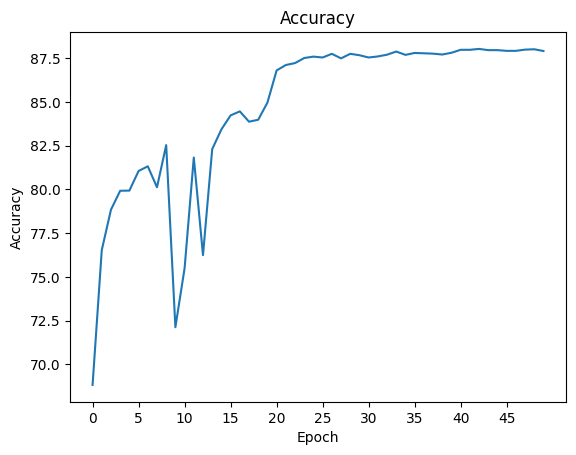

In [42]:
plt.plot(acc_list)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(0,50,5))
plt.ylabel('Accuracy')
plt.show()

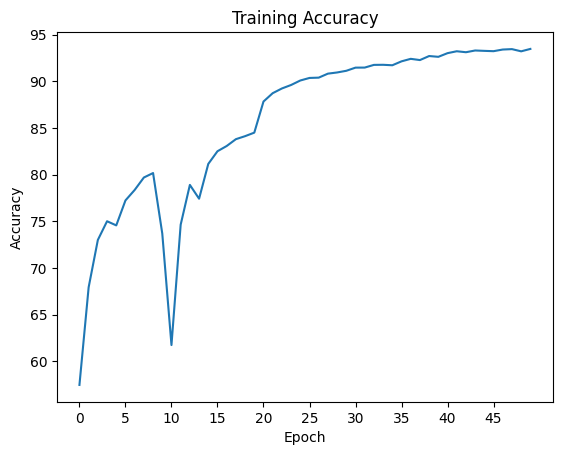

In [43]:
plt.plot(train_acc_list)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(0,50,5))
plt.ylabel('Accuracy')
plt.show()

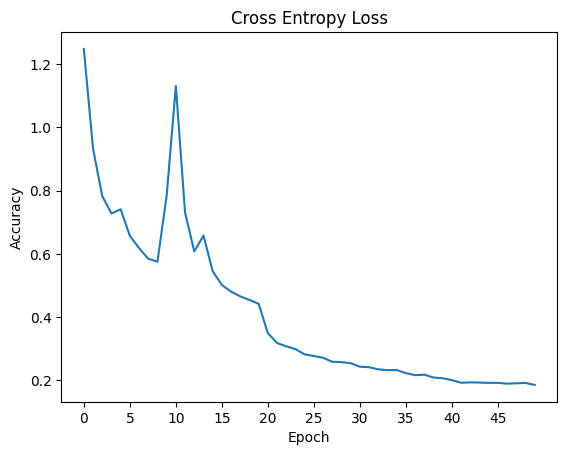

In [44]:
plt.plot(loss_list)
plt.title('Cross Entropy Loss')
plt.xlabel('Epoch')
plt.xticks(np.arange(0,50,5))
plt.ylabel('Accuracy')
plt.show()